In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(44)

In [3]:
import math
import time
import numpy as np
from copy import deepcopy
import pickle
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.nn import functional as F
from torch.utils.data import Subset
from tqdm import tqdm
from matplotlib import pyplot as plt

from data import plot_probs, plot_mentals
from data.othello import permit, start_hands, Othello, OthelloBoardState, permit_reverse
from mingpt.dataset import CharDataset
from mingpt.model import GPT, GPTConfig, GPTforProbeIA
from mingpt.utils import sample, intervene, print_board
from mingpt.probe_model import BatteryProbeClassification, BatteryProbeClassificationTwoLayer

In [4]:
def draw_board_heatmap(board, **kwargs):
    fig = plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    sns.heatmap(board.reshape(8, 8), **kwargs,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")
    return fig

In [5]:
def draw_heatmap_from_tokens(token_pred, **kwargs):
    # take off first token, as it isn't a board position
    token_pred = token_pred[1:]
    # add padding to get from tokens -> board positions
    padding = np.zeros(2)
    board = np.concatenate([token_pred[:27], padding, token_pred[27:33], padding, token_pred[33:]], axis=0)
    # plotting
    return draw_board_heatmap(board, **kwargs)

In [6]:
def load_probes(ckpt_path, layer_range):
    probes = {}
    for layer in layer_range:
        p = BatteryProbeClassificationTwoLayer(torch.cuda.current_device(), probe_class=3, num_task=64, mid_dim=256)
        load_res = p.load_state_dict(torch.load(f"./ckpts/{ckpt_path}/layer{layer}/checkpoint.ckpt"))
        p.eval()
        probes[layer] = p
    return probes

In [7]:
def load_model_layers(ckpt_path, layer_range):
    mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)

    models = {}
    for layer in layer_range:
        model = GPTforProbeIA(mconf, probe_layer=layer)
        # model = GPT(mconf)
        load_res = model.load_state_dict(torch.load(f"./ckpts/{ckpt_path}.ckpt"))
        if torch.cuda.is_available():
            device = torch.cuda.current_device()
            model = model.to(device)
        _ = model.eval()
        models[layer] = model

    return models, device

In [8]:
def intervene_predict(models, device, probes, layer_range, completion, wtd_list):
    # setting up partial game
    ab = OthelloBoardState()
    ab.update(completion)

    othello = Othello(n_games=10, deduplicate=False, quiet=True)
    train_dataset = CharDataset(othello)

    partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)

    # calculating pre intervention valid moves and predictions
    pre_intv_valids = [permit_reverse(_) for _ in ab.get_valid_moves()]
    print(pre_intv_valids)

    pre_intv_pred, _ = models[layer_range.stop-1](partial_game[None, :])  # [B, T, F=512]
    pre_intv_pred = pre_intv_pred[0, -1, :]
    pre_intv_pred = torch.softmax(pre_intv_pred, dim=0).detach().cpu().numpy()

    # settings for intervention optimization
    htd = {"lr": 1e-3, "steps": 1000, "reg_strg": 0.2}
    
    # setting up post intervention ground truth
    for wtd in wtd_list:
        move = permit(wtd["intervention_position"])
        r, c = move // 8, move % 8
        ab.state[r, c] = wtd["intervention_to"] - 1
    # ab.__print__()
    post_intv_valids = [permit_reverse(_) for _ in ab.get_valid_moves()]
    print(post_intv_valids)

    # setting up intervention
    p = probes[layer_range.start]
    whole_mid_act = models[layer_range.start].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]

    # intervene at the earlest interested layer 
    mid_act = whole_mid_act[0, -1]
    pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [64, 3]
    labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
    new_mid_act = mid_act.clone()
    for wtd in wtd_list:
        new_mid_act = intervene(p, new_mid_act, labels_pre_intv, wtd, htd, plot=True)
        pre_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
        labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
    post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]

    # swap in 
    whole_mid_act[0, -1] = new_mid_act

    for i, layer in enumerate(range(layer_range.start, layer_range.stop - 1)):  # 4, 5, 6, 7, indices of the layers to be passed
        p = probes[layer+1]
        whole_mid_act = models[layer_range.start].forward_2nd_stage(whole_mid_act, layer, layer+1)[0]  # [1, T, F=512]
        
        # intervene the output of the features freshly out
        mid_act = whole_mid_act[0, -1]
        pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [64, 3]

        labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
        new_mid_act = mid_act.clone()
        for wtd in wtd_list:
            new_mid_act = intervene(p, new_mid_act, labels_pre_intv, wtd, htd, plot=True)
            pre_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
            labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
        post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]

        # swap in 
        whole_mid_act[0, -1] = new_mid_act

    tb_resumed = whole_mid_act
    post_intv_pred, _ = models[layer_range.start].predict(tb_resumed)
    post_intv_pred = post_intv_pred[0, -1, :]
    post_intv_pred = torch.softmax(post_intv_pred, dim=0).detach().cpu().numpy()

    return pre_intv_pred, post_intv_pred
        

In [9]:
layer_range = range(4, 9)

In [10]:
models, device = load_model_layers("bias/TLcontrol", layer_range)
probes = load_probes("bias/probes/state_tl256_control", layer_range)

In [ ]:
with open("intervention_benchmark.pkl", "rb") as input_file:
    benchmark = pickle.load(input_file)

In [ ]:
case_id = 777
wtd = {
    "intervention_position": permit_reverse(benchmark[case_id]["pos_int"]), 
    "intervention_from": benchmark[case_id]["ori_color"], 
    "intervention_to": 2 - benchmark[case_id]["ori_color"], 
}
completion = benchmark[case_id]["history"]
print(wtd)

In [62]:
games = Othello(data_root="othello_synthetic", n_games=100, deduplicate=False)
# white 0, blank 1, black 2
wtd = {
    "intervention_position": "e5", 
    "intervention_from": 0, 
    "intervention_to": 1, 
}
completion = games[5][:20]
print(wtd)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 4.31 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 80 for training, 20 for validation
{'intervention_position': 'e5', 'intervention_from': 0, 'intervention_to': 1}


In [63]:
ob = OthelloBoardState()
ob.update(completion, prt=True)

--------------------
[]
a                
b                
c                
d       O X      
e       X O      
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['c4']
a                
b                
c       X        
d       X X      
e       X O      
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['c4', 'e3']
a                
b                
c       X        
d       X X      
e     O O O      
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['c4', 'e3', 'f2']
a                
b                
c       X        
d       X X      
e     X O O      
f   X            
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['c4', 'e3', 'f2', 'c3']
a                
b                
c     O X        
d       O X      
e     X O O      
f   X 

In [64]:
full_board_wtds = []
state = ob.get_state()
for i in range(64):
    current = int(state[i])
    full_board_wtds.append({
        "intervention_position": permit_reverse(i), 
        "intervention_from": current, 
        "intervention_to": (current + 1) % 3, 
    })
    full_board_wtds.append({
        "intervention_position": permit_reverse(i), 
        "intervention_from": current, 
        "intervention_to": (current + 2) % 3, 
    })
print(len(full_board_wtds))
    

128


In [ ]:
pre, post = intervene_predict(models, device, probes, layer_range, completion, wtd_list)

In [ ]:
fig = draw_heatmap_from_tokens(pre)
fig = draw_heatmap_from_tokens(post)

In [66]:
results = []
for wtd in full_board_wtds:
    wtd_list = [wtd]
    pre, post = intervene_predict(models, device, probes, layer_range, completion, wtd_list)
    results.append((completion, wtd_list, pre, post))

Dataset created has 8 sequences, 61 unique words.
['a4', 'b4', 'c6', 'd3', 'd7', 'e8', 'g6', 'g8', 'h8']
['a4', 'b4', 'c6', 'd3', 'd7', 'e8', 'g6', 'g8', 'h8']
a1 Sucessfully intervened!
a1 Sucessfully intervened!
a1 Sucessfully intervened!
a1 Sucessfully intervened!
a1 Sucessfully intervened!
Dataset created has 8 sequences, 61 unique words.
['a4', 'b4', 'c6', 'd3', 'd7', 'e8', 'g6', 'g8', 'h8']
['a4', 'b4', 'c6', 'd3', 'd7', 'e8', 'g6', 'g8', 'h8']
a1 Sucessfully intervened!
a1 Sucessfully intervened!
a1 Sucessfully intervened!
a1 Sucessfully intervened!
a1 Sucessfully intervened!
Dataset created has 8 sequences, 61 unique words.
['a4', 'b4', 'c6', 'd3', 'd7', 'e8', 'g6', 'g8', 'h8']
['b4', 'c6', 'd3', 'd7', 'e8', 'g6', 'g8', 'h8']
a2 Sucessfully intervened!
a2 Sucessfully intervened!
a2 Sucessfully intervened!
a2 Sucessfully intervened!
a2 Sucessfully intervened!
Dataset created has 8 sequences, 61 unique words.
['a4', 'b4', 'c6', 'd3', 'd7', 'e8', 'g6', 'g8', 'h8']
['b4', 'c6', 'd3

In [79]:
import matplotlib.patches as patches

def intervention_heatmap(wtd_list, pre_pred, post_pred):
    def convert_tokens2board(token_pred):
        # take off first token, as it isn't a board position
        token_pred = token_pred[1:]
        # add padding to get from tokens -> board positions
        padding = np.zeros(2)
        board = np.concatenate([token_pred[:27], padding, token_pred[27:33], padding, token_pred[33:]], axis=0)
        return board
    
    def heat(axs, data):
        return sns.heatmap(data=data.reshape((8, 8)), ax=axs, vmin=0, vmax=0.2, 
                        annot=True, fmt=".2f",
                        yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)))
    
    def highlight_intv(ax, wtd):
        move = permit(wtd['intervention_position'])
        r, c = move // 8, move % 8
        ax.add_patch(patches.Rectangle((c, r), 1, 1, linewidth=4, edgecolor='white', facecolor='none'))

    def highlight_valid_moves(ax, ob):
        for move in ob.get_valid_moves():
            r, c = move // 8, move % 8
            ax.add_patch(patches.Rectangle((c, r), 1, 1, linewidth=2, edgecolor='blue', facecolor='none'))

    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Pre')
    axs[1].set_title('Post')

    ax1 = heat(axs[0], convert_tokens2board(pre_pred))
    ax2 = heat(axs[1], convert_tokens2board(post_pred))

    # pre board state
    ob = OthelloBoardState()
    ob.update(completion)
    highlight_valid_moves(ax1, ob)
    # post board state
    for wtd in wtd_list:
        move = permit(wtd["intervention_position"])
        r, c = move // 8, move % 8
        ob.state[r, c] = wtd["intervention_to"] - 1
    highlight_valid_moves(ax2, ob)

    highlight_intv(ax2, wtd)

    plt.tight_layout()
    plt.show()

[{'intervention_position': 'b4', 'intervention_from': 1, 'intervention_to': 0}]


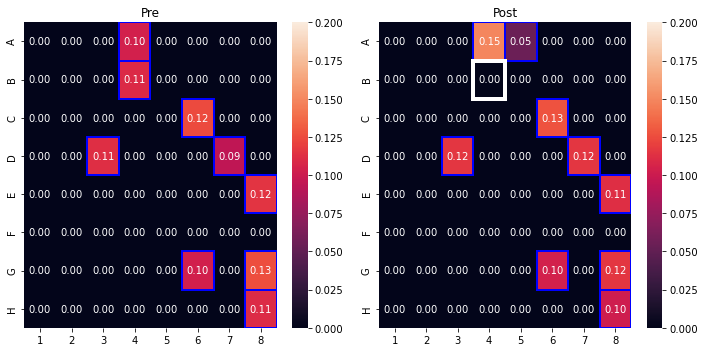

In [83]:
for r in results[23:24]:
    completion, wtd_list, pre, post = r
    print(wtd_list)
    intervention_heatmap(wtd_list, pre, post)

In [68]:
def apply_wtds(ob, wtd_list):
    for wtd in wtd_list:
        move = permit(wtd["intervention_position"])
        r, c = move // 8, move % 8
        ob.state[r, c] = wtd["intervention_to"] - 1

In [114]:
from scipy.stats import entropy

othello = Othello(n_games=10, deduplicate=False, quiet=True)
train_dataset = CharDataset(othello)

e = []

for r in results:
    completion, wtd_list, pre_pred, post_pred = r
    test = wtd_list[0]
    if test['intervention_position'] in ['d4', 'd5', 'e4', 'e5'] and test['intervention_to'] == 1:
        print("skipping empty center")
        continue

    ob = OthelloBoardState()
    ob.update(completion)

    pre_valid = ob.get_valid_moves()
    apply_wtds(ob, wtd_list)
    post_valid = ob.get_valid_moves()

    pre_valid_tokens = [train_dataset.stoi[i] for i in pre_valid]
    pre_legal_pred = pre_pred[pre_valid_tokens]

    post_valid_tokens = [train_dataset.stoi[i] for i in post_valid]
    post_legal_pred = post_pred[post_valid_tokens]
    
    ideal = np.zeros(post_pred.shape) + 1e-6
    ideal[post_valid_tokens] = 1 / len(post_valid_tokens)

    ce = entropy(post_pred) + entropy(post_pred, ideal)
    # print(ce)

    # print(entropy(post_pred))
    # print(entropy(post_pred, ideal))

    # n = len(post_legal_pred)
    # qk = np.ones(n) / n

    # ce = entropy(post_legal_pred) + entropy(post_legal_pred, qk)
    # print(ce)

    e.append((ce, r))

e.sort(key=lambda x: x[0])
print("min entropy:", e[0][0])

Dataset created has 8 sequences, 61 unique words.
skipping empty center
skipping empty center
skipping empty center
skipping empty center
min entropy: 1.9624976943576904


1.9624976943576904
--------------------
['c4', 'e3', 'f2', 'c3', 'c2', 'd6', 'c5', 'b2', 'e7', 'c7', 'a2', 'c1', 'f5', 'a3', 'd2', 'f6', 'f7', 'f8', 'e6', 'g7']
a   X O          
b   X            
c O X O X X   O  
d   X   O X O    
e     X X O X O  
f   X     X O O O
g             O  
h                
  1 2 3 4 5 6 7 8
--------------------
{'intervention_position': 'e6', 'intervention_from': 2, 'intervention_to': 0}


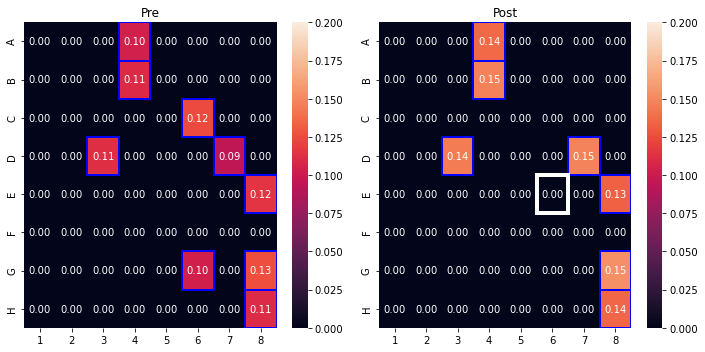

2.048245617815211
--------------------
['c4', 'e3', 'f2', 'c3', 'c2', 'd6', 'c5', 'b2', 'e7', 'c7', 'a2', 'c1', 'f5', 'a3', 'd2', 'f6', 'f7', 'f8', 'e6', 'g7']
a   X O          
b   X            
c O X O X X   O  
d   X   O X O    
e     X X O X O  
f   X     X O O O
g             O  
h                
  1 2 3 4 5 6 7 8
--------------------
{'intervention_position': 'd5', 'intervention_from': 2, 'intervention_to': 0}


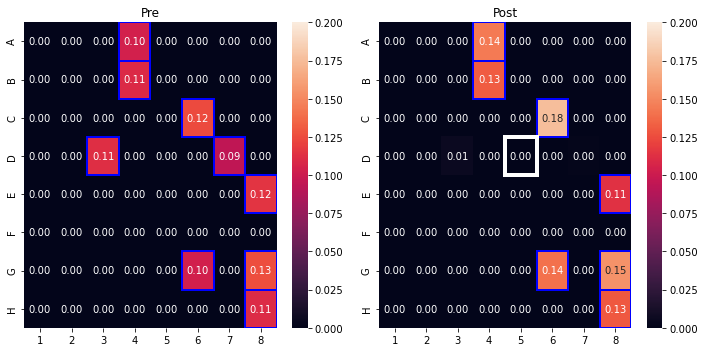

2.0889833668528777
--------------------
['c4', 'e3', 'f2', 'c3', 'c2', 'd6', 'c5', 'b2', 'e7', 'c7', 'a2', 'c1', 'f5', 'a3', 'd2', 'f6', 'f7', 'f8', 'e6', 'g7']
a   X O          
b   X            
c O X O X X   O  
d   X   O X O    
e     X X O X O  
f   X     X O O O
g             O  
h                
  1 2 3 4 5 6 7 8
--------------------
{'intervention_position': 'b4', 'intervention_from': 1, 'intervention_to': 2}


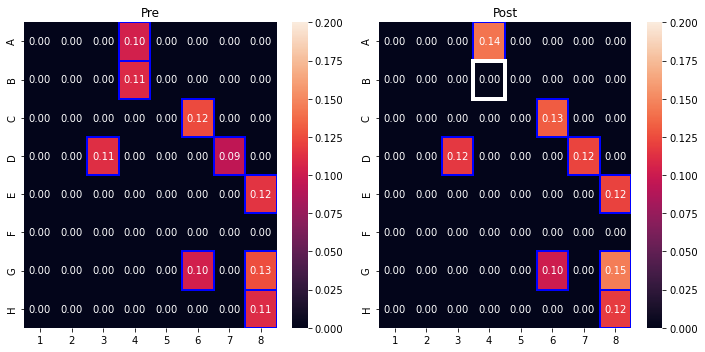

2.0897379498576347
--------------------
['c4', 'e3', 'f2', 'c3', 'c2', 'd6', 'c5', 'b2', 'e7', 'c7', 'a2', 'c1', 'f5', 'a3', 'd2', 'f6', 'f7', 'f8', 'e6', 'g7']
a   X O          
b   X            
c O X O X X   O  
d   X   O X O    
e     X X O X O  
f   X     X O O O
g             O  
h                
  1 2 3 4 5 6 7 8
--------------------
{'intervention_position': 'h8', 'intervention_from': 1, 'intervention_to': 0}


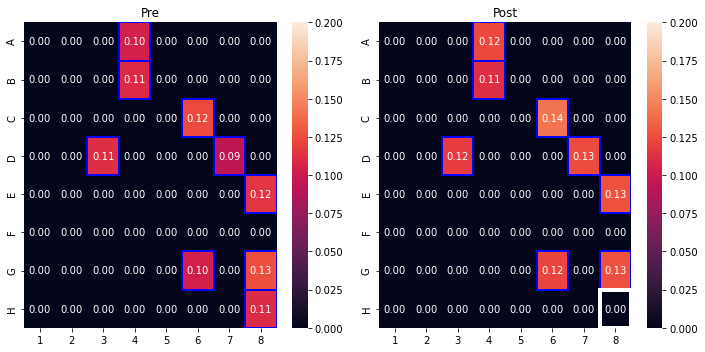

2.0931058678562198
--------------------
['c4', 'e3', 'f2', 'c3', 'c2', 'd6', 'c5', 'b2', 'e7', 'c7', 'a2', 'c1', 'f5', 'a3', 'd2', 'f6', 'f7', 'f8', 'e6', 'g7']
a   X O          
b   X            
c O X O X X   O  
d   X   O X O    
e     X X O X O  
f   X     X O O O
g             O  
h                
  1 2 3 4 5 6 7 8
--------------------
{'intervention_position': 'c3', 'intervention_from': 0, 'intervention_to': 2}


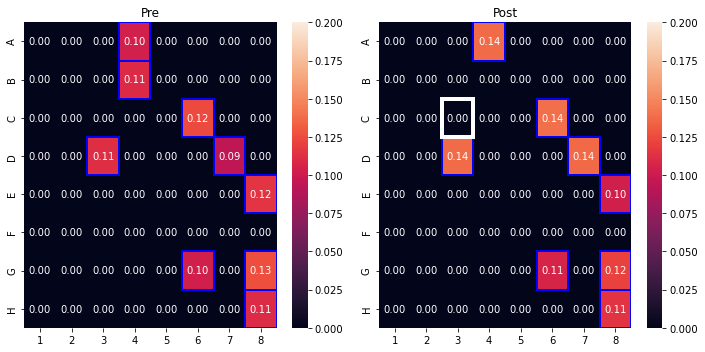

In [116]:
for r in e[:5]:
    print(r[0])
    completion, wtd_list, pre, post = r[1]
    ob = OthelloBoardState()
    ob.update(completion)
    ob.__print__()
    print(wtd_list[0])
    intervention_heatmap(wtd_list, pre, post)